# Dataset Proposal v.1.0

#### 1. Input original data from coordinates.csv and test if data is correct
<font size=2>
  
The **coordinates.csv** is generated from **MCS_chart.ipynb** after selecting recognizable data. Note that the original unit from Unknown.csv was **mm**, but the extracted data into **coordinates.csv** has already been transferred into **m**.
    
Here are indices and corresponding joints in each coordinate-array (i.e.x_coord,y_coord,z_coord), **after** eliminating columns of **center of gravity**:
    
    0:LWrist 1:LElbow 2:LShoulder
    3:RWrist 4:RElbow 5:RShoulder
    6:LToe 7:LAnkle 8:LKnee 9:LHip
    10:RToe 11:RAnkle 12:RKnee 13:RHip
    14:LClavicle 15:LHandEnd 16:LToesEnd
    17:RClavicle 18:RHandEnd 19:RToesEnd
    20:spine1 21:spine2 22:spine3 23:spine4 24:spine5 25:head 
    
</font>

original array from coordinates.csv has shape: (600, 81)
coordinate-array(i.e, x_coord) has shape: (600, 26)


<IPython.core.display.Javascript object>


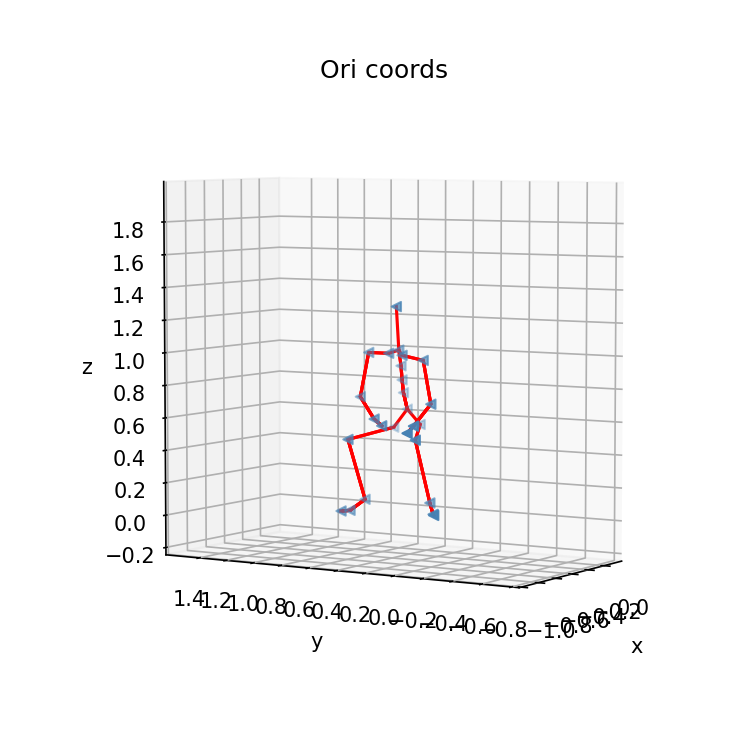

In [4]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime as dt
from itertools import count
%matplotlib inline
# to rotate 3D plot interactively
%matplotlib notebook
# Test if coordinates.csv is correct

def get_coords(path):
    csv_df = pd.read_csv(path,header=None) # ,header=None
    csv_np = csv_df.to_numpy()
    print(f'original array from coordinates.csv has shape: {csv_np.shape}')
    cogs = csv_np[:,0:3]
    x_coord = csv_np[:,3::3]
    y_coord = csv_np[:,4::3]
    z_coord = csv_np[:,5::3]
    
    joints_dict = {'left arm': [15,0,1,2,14,24],
                  'right arm': [18,3,4,5,17,24],
                  'left leg': [16,6,7,8,9,20],
                  'right leg': [19,10,11,12,13,20],
                  'spine': [20,21,22,23,24,25]
                 }
    
    print(f'coordinate-array(i.e, x_coord) has shape: {x_coord.shape}')
    return x_coord,y_coord,z_coord,joints_dict

def connect(frame,ax,joints):
    idx_lst = [[],[],[]]
    for i in joints:
        idx_lst[0].append(frame[0][i])
        idx_lst[1].append(frame[1][i])
        idx_lst[2].append(frame[2][i])
        ax.plot(idx_lst[0], idx_lst[1], idx_lst[2], color='red')

def connect_with_lines(frame,ax,joints_dict):
    for links,joints in joints_dict.items():
        connect(frame,ax,joints)
        
def prepare_ax(coords,ax):
    # axis label
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # axis limit
    x_high, x_low = int(np.ceil(coords[0].max()*1000/200.0))*200, int(np.floor(coords[0].min()*1000/200.0))*200
    y_high, y_low = int(np.ceil(coords[2].max()*1000/200.0))*200, int(np.floor(coords[2].min()*1000/200.0))*200
    z_high, z_low = int(np.ceil(coords[1].max()*1000/200.0))*200, int(np.floor(coords[1].min()*1000/200.0))*200
    ax.axes.set_xlim3d(left=x_low/1000.0, right=x_high/1000.0) 
    ax.axes.set_ylim3d(bottom=y_low/1000.0, top=y_high/1000.0)
    ax.axes.set_zlim3d(bottom=z_low/1000.0, top=z_high/1000.0)
    # axis scale
    ax.set_xticks(list(i/1000.0 for i in range(x_low,x_high,200)))
    ax.set_yticks(list(i/1000.0 for i in range(y_low,y_high,200)))
    ax.set_zticks(list(i/1000.0 for i in range(z_low,z_high,200)))
    # axis aspect ratio
    ax.set_box_aspect(aspect = (x_high-x_low,y_high-y_low,z_high-z_low))
    
def plot_func(frame_id):
    # plot links in 3D 
    ax1.cla()
    coords = [x_coord,y_coord,z_coord]
    current_frame_1 = [coords[0][frame_id], coords[2][frame_id], coords[1][frame_id]] # x_pos,z_pos,y_pos
    prepare_ax(coords,ax1)
    ax1.set_title(f'Ori coords')
    ax1.scatter3D(current_frame_1[0], current_frame_1[1], current_frame_1[2], c='steelblue', marker='<')
    connect_with_lines(current_frame_1,ax1,joints_dict)

path = 'Dataset_Proposal/coordinates.csv'
x_coord,y_coord,z_coord,joints_dict = get_coords(path)
N_frames = 600
fig = plt.figure(figsize=(5,5))
fig.tight_layout()

# plot links in 3D 
ax1 = fig.add_subplot(projection='3d')
ani = animation.FuncAnimation(fig,plot_func,frames=N_frames,interval=17)
plt.show()

#### 2.1 Calculation of all distances
<font size=2>
    
Calculate distances between every 2 joints and save in a 2D array. E.g. there are 26 joints, then the distance-array has shape [26,26], each element [i,j] represents the distance between **joint i** and **joint j**.
    
</font>

In [25]:
def calc_distances_timeline(x_coord,y_coord,z_coord):
    num_frame, num_joints = x_coord.shape
    # e,g, all_distances[3,1,4] means distance between LElbow and RElbow in 3rd frame
    all_distances = np.zeros((num_frame,num_joints,num_joints))
#     print(f'{num_frame} frames, {num_joints} joints')
    x_coord = np.expand_dims(x_coord, axis=1)
    y_coord = np.expand_dims(y_coord, axis=1)
    z_coord = np.expand_dims(z_coord, axis=1)
#     print(f'{x_coord.shape}')
    all_distances = np.sqrt((x_coord - np.transpose(x_coord,(0,2,1)))**2 
                            + (y_coord - np.transpose(y_coord,(0,2,1)))**2 
                            + (z_coord - np.transpose(z_coord,(0,2,1)))**2
                           )
#     print(f'all_distances shape: {all_distances.shape}')
    return all_distances

x_coord,y_coord,z_coord,joints_dict = get_coords(path)
all_distances = calc_distances_timeline(x_coord,y_coord,z_coord)
# print(all_distances[0])

original array from coordinates.csv has shape: (600, 81)
coordinate-array(i.e, x_coord) has shape: (600, 26)


#### 2.2 Examine whether distances are calculated correctly
<font size=2>
    
From 2.1, an array with shape [600,26,26] is obtained, which means there are 600 frames, in each frame there are distances between random 2 joints (from all 26 joints).
    
Below is the way to examine whether the array fulfills the expectation, i.e. whether the array truely contains information of distances.
    
</font>

In [30]:
def get_joint_index():
    joint_index_dict = {'LWrist':0, 'LElbow':1, 'LShoulder':2,
                   'RWrist':3, 'RElbow':4, 'RShoulder':5,
                   'LToe':6, 'LAnkle':7, 'LKnee':8, 'LHip':9,
                   'RToe':10, 'RAnkle':11, 'RKnee':12, 'RHip':13,
                   'LClavicle':14, 'LHandEnd':15, 'LToesEnd':16,
                   'RClavicle':17, 'RHandEnd':18, 'RToesEnd':19,
                   'spine1':20, 'spine2':21, 'spine3':22, 'spine4':23, 'spine5':24, 'head':25
                  }
    return joint_index_dict

def examine_distance(frame, joint_1, joint_2):
    joint_index_dict = get_joint_index()
    joint_1_idx = joint_index_dict[joint_1]
    joint_2_idx = joint_index_dict[joint_2]
    dist_from_array = all_distances[frame,joint_1_idx,joint_2_idx]
    dist_calculated = np.sqrt((x_coord[frame,joint_1_idx] - x_coord[frame,joint_2_idx])**2 
                        + (y_coord[frame,joint_1_idx] - y_coord[frame,joint_2_idx])**2 
                        + (z_coord[frame,joint_1_idx] - z_coord[frame,joint_2_idx])**2
                       )
    print(f'distance indexed from distances array: {dist_from_array}')
    print(f'distance calculated from coordinates: {dist_calculated}')
    print(f'wehther the same: {dist_from_array == dist_calculated}')

frame = 359
joint_1 = 'RHandEnd'
joint_2 = 'LHandEnd'
x_coord,y_coord,z_coord,joints_dict = get_coords(path)
all_distances = calc_distances_timeline(x_coord,y_coord,z_coord)
examine_distance(frame, joint_1, joint_2)

original array from coordinates.csv has shape: (600, 81)
coordinate-array(i.e, x_coord) has shape: (600, 26)
distance indexed from distances array: 0.3897396367325362
distance calculated from coordinates: 0.3897396367325362
wehther the same: True


#### 3. Calculation of angles
<font size=2>
    
Calculate angles between every 2 adjacent links and save in a dictionary. E.g. {"RUpperArm_RLowerArm":230} represents the angle between **right upper arm link** and **right lower arm link** is 230°.
    
</font>

In [33]:
a = np.arange(0,4,1)
a = np.expand_dims(a, axis=0)
sub = a - a.T
print(a,a.shape)
print(sub)

[[0 1 2 3]] (1, 4)
[[ 0  1  2  3]
 [-1  0  1  2]
 [-2 -1  0  1]
 [-3 -2 -1  0]]


In [17]:
import numpy as np
a = [1,2,3,4]
b = [1,2,3,4]
print(np.all(a==b))

True
